## Use ARIMA, autoARIMA, SARIMA, and SARIMAX Machine Learning Model for Time Series forecasting

##### **ARIMA**: AutoRegressive Integrated Moveing Averag

##### **autoARIMA**: automated ARIMA model 

##### **SARIMA**: Seasonal ARIMA 

##### **SRIMAAX**: multiplicative SARIMA

### Our project is trying to use machine learning tool to predict how many new companies will come up from the future

In [10]:
# Import dependencies
import pandas as pd
import numpy as np
from numpy import log
# from numpy import removeOutliers
import os
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import datetime as dt
from dateutil.parser import parse 
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf
import pmdarima as pm
import seaborn as sns
from fbprophet import Prophet

### Visualizing original time series

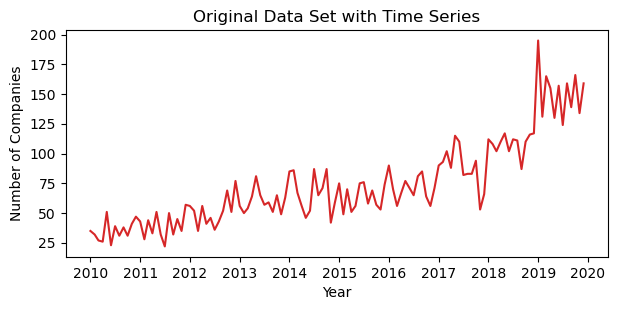

In [5]:
# Load data
df = pd.read_csv('2010_zip_1_monthly_data.csv', parse_dates=['date'], index_col='date')

# Draw Plot
def plot_df(df, x, y, title="", xlabel='Year', ylabel='Number of Companies', dpi=100):
    plt.figure(figsize=(7,3), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.savefig('1_raw_data_ts.png')
    plt.show()

plot_df(df, x=df.index, y=df.value, title='Original Data Set with Time Series')   

##### The original raw data showing the fluctuations

### Calculate data outliers as standard data analysis procedure. In this perticular example, we add the seasonality and forecasting features in the calculatoin just want to see if the outlier can make influence of the seasonal forecasting

In [11]:
#  Read in data
df = pd.read_csv('2010_zip_1_monthly_data.csv')
df1 = df.rename(columns = {'date':'ds','value':'y'})
# df1.head()

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


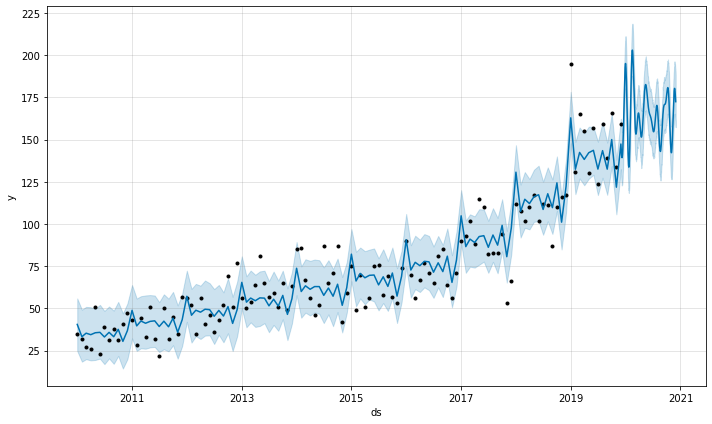

In [12]:
# Calculate outliers
from fbprophet import Prophet
m = Prophet(seasonality_mode='multiplicative').fit(df1)
future = m.make_future_dataframe(periods=365)
fcst = m.predict(future)
fig = m.plot(fcst)
plt.savefig('forecasting_with_outliers.png')

##### The plot showed the outliers in our data is not big enough to affecting the seasonal forcasting, so we will directly use the data without remove the ourliers

### Outliers included in uncertainty yearly trend (top plot) and uncertainty monthly trend with seasonality combined (bottom plot)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


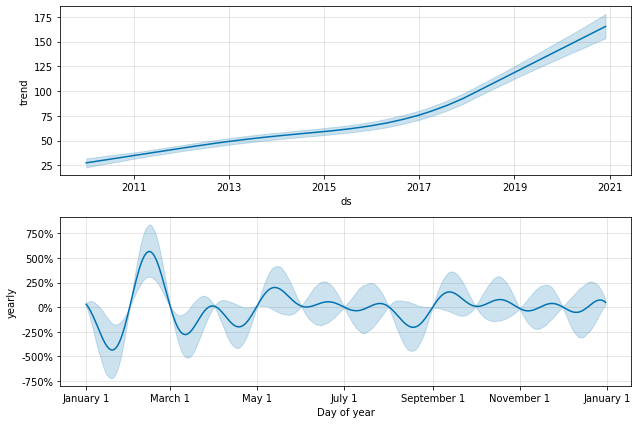

In [14]:
m = Prophet(seasonality_mode='multiplicative', mcmc_samples=365).fit(df1)
fcst = m.predict(future)
fig = m.plot_components(fcst)
plt.savefig('outlier_with_forecasting.png')

### Building a horizontally seasonality comparison for each year new companies grown over time

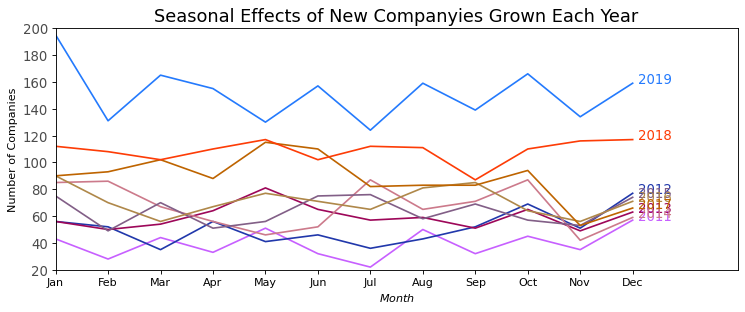

In [8]:
# Import Data
df = pd.read_csv('2010_zip_1_monthly_data_date.csv', parse_dates=['date'], index_col='date')
df.reset_index(inplace=True)

# Prepare data on yearly and monthly comparison
df['year'] = [d.year for d in df.date]
df['month'] = [d.strftime('%b') for d in df.date]
years = df['year'].unique()

# Define plot colors
np.random.seed(100)
mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(years), replace=False)

# Draw Plot
plt.figure(figsize=(11,4), dpi= 80)
for i, y in enumerate(years):
    if i > 0:        
        plt.plot('month', 'value', data=df.loc[df.year==y, :], color=mycolors[i], label=y)
        plt.text(df.loc[df.year==y, :].shape[0]-.9, df.loc[df.year==y, 'value'][-1:].values[0], y, fontsize=12, color=mycolors[i])

# Necessary description of the plot
plt.gca().set(xlim=(0, 13), ylim=(20, 200), ylabel='Number of Companies', xlabel='$Month$')
plt.yticks(fontsize=12, alpha=.7)
plt.title("Seasonal Effects of New Companyies Grown Each Year", fontsize=16)
plt.savefig('2_seasonal_ts.png')
plt.show()

### Build seasonality comparison charts. It is easy to see overall number of companies increasing over time vertically

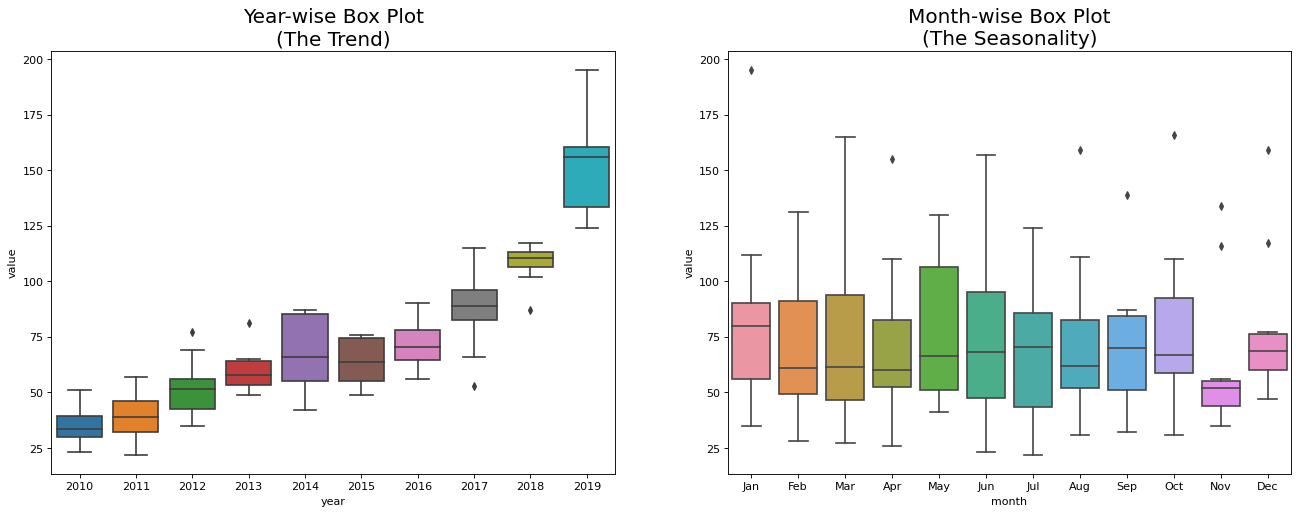

In [9]:
# Import Data
df = pd.read_csv('2010_zip_1_monthly_data.csv', parse_dates=['date'], index_col='date')
df.reset_index(inplace=True)

# Prepare data
df['year'] = [d.year for d in df.date]
df['month'] = [d.strftime('%b') for d in df.date]
years = df['year'].unique()

# Draw Plot
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='year', y='value', data=df, ax=axes[0])
sns.boxplot(x='month', y='value', data=df.loc[~df.year.isin([1991, 2008]), :])

# Set Title
axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18); 
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.savefig('3_yearly_and_seasonal_trends.png')
plt.show()

### Build charts to compare the differences between trend only, seasonality only, and trend with seasonality combined over time series

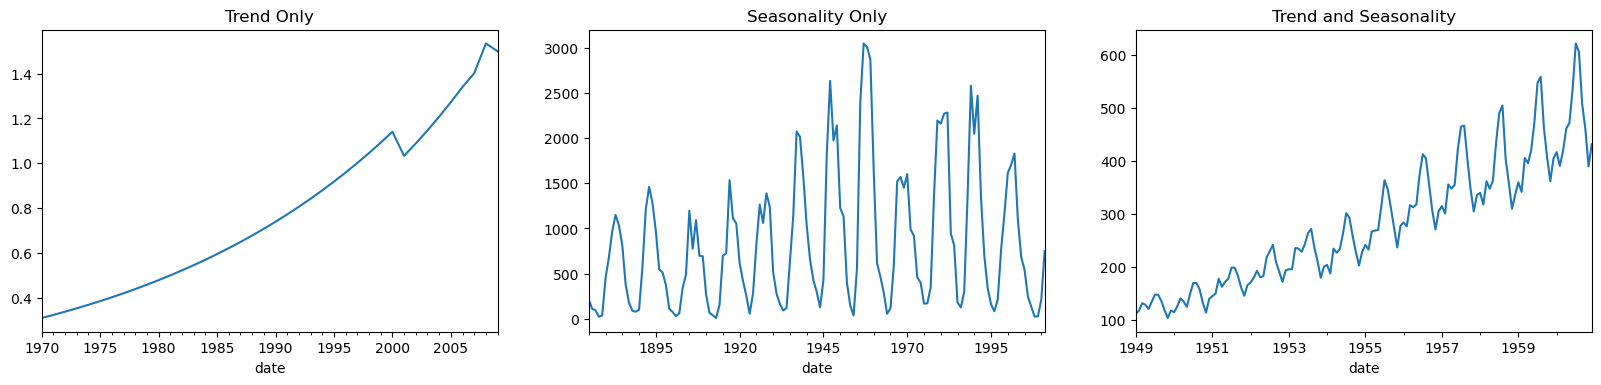

In [10]:
# Base-trend, seasonality-only, and tread with seasonality comparison
fig, axes = plt.subplots(1,3, figsize=(20,4), dpi=100)
pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/guinearice.csv', parse_dates=['date'], index_col='date').plot(title='Trend Only', legend=False, ax=axes[0])

pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/sunspotarea.csv', parse_dates=['date'], index_col='date').plot(title='Seasonality Only', legend=False, ax=axes[1])

pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/AirPassengers.csv', parse_dates=['date'], index_col='date').plot(title='Trend and Seasonality', legend=False, ax=axes[2])
plt.savefig('4_trend_seasonal_trendANDseasonal_comparison.png')

### Before to use ARIMA model for prediction, we need to do some data pre-testing. One of the important step is to test if our data falls in null hypothesis. If p < 0.05, means our data samples in this time series no variation, which is stationary. 

In [11]:
# Use different test packege to check if our data in the time series stationary (p<=0.0.5)
from statsmodels.tsa.stattools import adfuller, kpss
df = pd.read_csv('2010_zip_1_monthly_data.csv', parse_dates=['date'])

# ADF (Augmented Dickey Fuller) test
result = adfuller(df.value.values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

# KPSS (Kwiatkowski-Phillips-Schmidt-Shin) test
result = kpss(df.value.values, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: 2.625523811143773
p-value: 0.9990794409774549
Critial Values:
   1%, -3.4924012594942333
Critial Values:
   5%, -2.8886968193364835
Critial Values:
   10%, -2.5812552709190673

KPSS Statistic: 0.857514
p-value: 0.010000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


C:\Users\foxru\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1661: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
C:\Users\foxru\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1685: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


###### The above results showed us the ADP is none significant, but KPSS result is significant, so our data most likely is not stationary

### Compare our data in multiplicative and additive decomposation forms to see the diferences on each component between trend only, seasonal only, and trend with seasonal combination, and residual errors

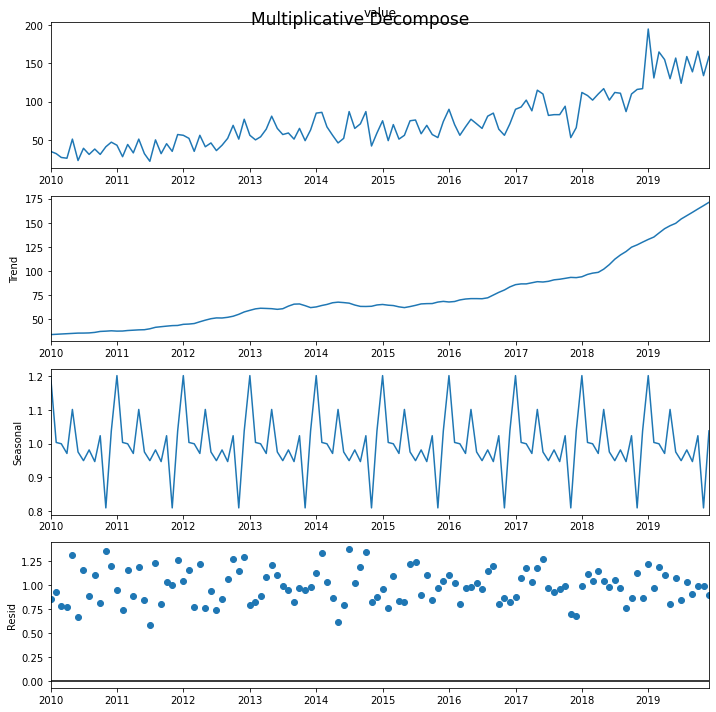

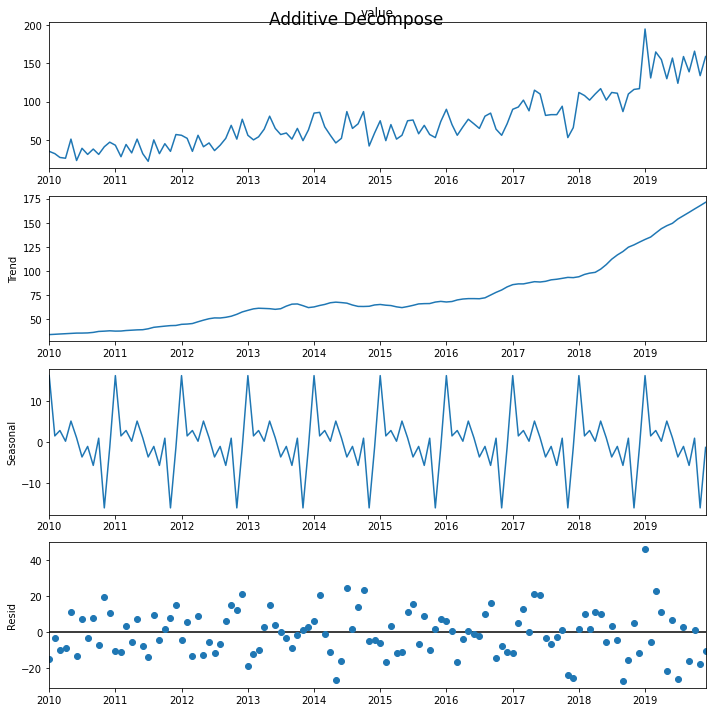

In [12]:
# Time series decomposed into its components
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

# Import Data
df = pd.read_csv('2010_zip_1_monthly_data.csv', parse_dates=['date'], index_col='date')

# Multiplicative Decomposition 
result_mul = seasonal_decompose(df['value'], model='multiplicative', extrapolate_trend='freq')

# Additive Decomposition
result_add = seasonal_decompose(df['value'], model='additive', extrapolate_trend='freq')

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result_mul.plot().suptitle('Multiplicative Decompose', fontsize=17)
result_add.plot().suptitle('Additive Decompose', fontsize=17)
plt.savefig('ts_decomposed_components.png')
plt.show()

### After examine our data, step 1 is to use the ADF test to find the order of differencing in ARIMA model. If p < 0.05, means the series stationary and d = 0

In [13]:
# ADF test to determine the minimum number of differencing d value
result = adfuller(df.value)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: 2.625524
p-value: 0.999079


##### Since p-value is none significant, we need to find the minimum differencing value of d 

### Step2. Find the order of AR term (p) for ARIMA model. Part1 is inspecting the partial autocorrelation function (PACF) result, which is the correlation between the series and its lag. 

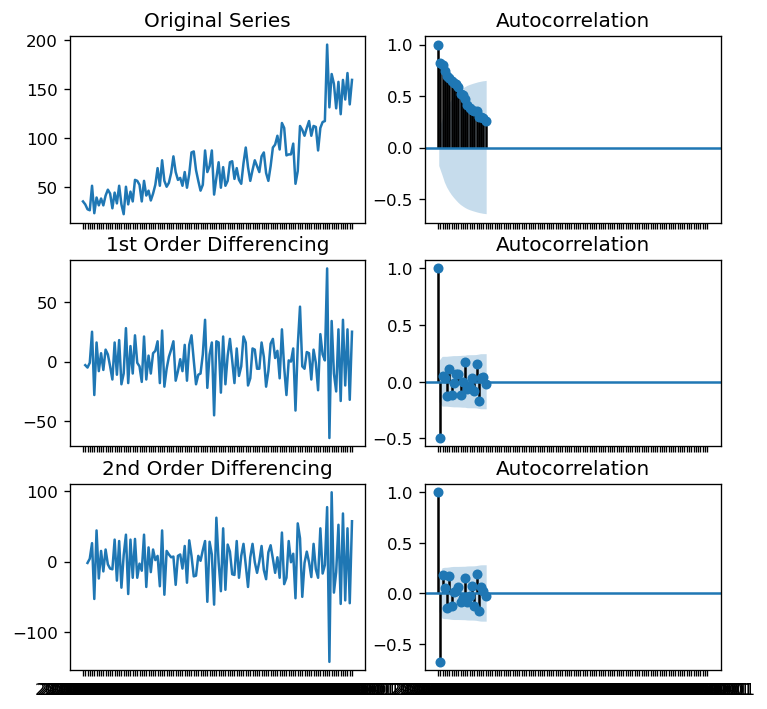

In [14]:
# Find the order of the AR term (p): The lags of y to be used as predictor

# Read in data
df = pd.read_csv('2010_zip_1_monthly_data.csv', names=['value'], header=0)

plt.rcParams.update({'figure.figsize':(7,7), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(df.value); axes[0, 0].set_title('Original Series')
plot_acf(df.value, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df.value.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df.value.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df.value.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df.value.diff().diff().dropna(), ax=axes[2, 1])
plt.savefig('9_pacf_test_for_AR_order_p_test.png')

plt.show()

##### After the autocorrelation function test, the difference goes to '0' very quick. At this point, we can set d = 1.

### Step 2 part2 is find the order of AR term P: the number of AR lags fall into the significant p value region

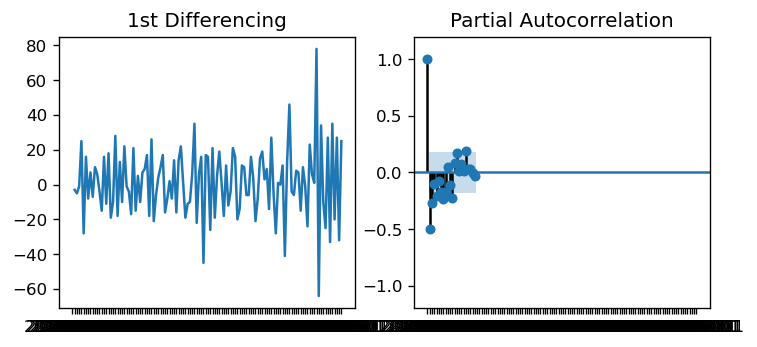

In [15]:
# Use partial autocorrelation function (PACF) to inspect for AR lag(s)
plt.rcParams.update({'figure.figsize':(7,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df.value.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(-1.2,1.2))
plot_pacf(df.value.diff().dropna(), ax=axes[1])
plt.savefig('1stdifferencing_AR_order.png')

plt.show()

##### From the graph, we know the first differencing fall into the significant region, so we can set AR = 1

### Find the order of the MA term (q): number of laggerd forecast error that need to go to the model. This parameter can let the model know how many lagged errors need to be removed from the stationary process in the series

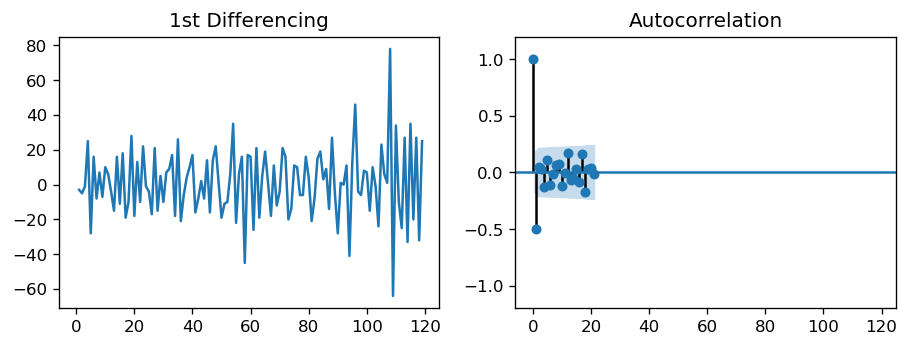

In [27]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

# Import data
df = pd.read_csv('2010_zip_1_monthly_data.csv')

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df.value.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(-1.2,1.2))
plot_acf(df.value.diff().dropna(), ax=axes[1])
plt.savefig('1stdiffernecing_MA_order.png')

plt.show()

##### From the graph, we know the first differencing fall into the significant region, so we can set MA = 1

### Test ARIMA model by using differrent sets of parameters d, p(AR), and q(MA) that we get from pacf and acf tests and find the best parameter set for build the training model. The AIC (Akeike Information Criteria) value in the model summary table is an indecator of how good the model fitted. The lower AIC value, the better fit. 

In [14]:
# Build ARIMA Model1, d=1, AR=1, MA=1
model = ARIMA(df.value, order=(1,1,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                  119
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -497.292
Method:                       css-mle   S.D. of innovations             15.739
Date:                Tue, 31 Mar 2020   AIC                           1002.584
Time:                        15:44:07   BIC                           1013.701
Sample:                             1   HQIC                          1007.098
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             1.0188      0.324      3.145      0.002       0.384       1.654
ar.L1.D.value     0.0478      0.115      0.415      0.678      -0.178       0.273
ma.L1.D.value    -0.7931      0.069    -

In [15]:
# Building ARIMA Model2, d=1, AR=0, MA=1
model = ARIMA(df.value, order=(1,0,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())

C:\Users\foxru\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:220: RuntimeWarning: divide by zero encountered in true_divide
  Z_mat, R_mat, T_mat)
C:\Users\foxru\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\foxru\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\foxru\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\foxru\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()


                              ARMA Model Results                              
Dep. Variable:                  value   No. Observations:                  120
Model:                     ARMA(1, 1)   Log Likelihood                -505.763
Method:                       css-mle   S.D. of innovations             16.177
Date:                Tue, 31 Mar 2020   AIC                           1019.527
Time:                        15:44:24   BIC                           1030.677
Sample:                             0   HQIC                          1024.055
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          87.0260     44.677      1.948      0.051      -0.540     174.592
ar.L1.value     0.9947      0.007    137.774      0.000       0.981       1.009
ma.L1.value    -0.6786      0.069     -9.791    

In [79]:
# Building ARIMA Model3, d=0, AR=1, MA=1
model = ARIMA(df.value, order=(0,1,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                  119
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -497.377
Method:                       css-mle   S.D. of innovations             15.750
Date:                Tue, 31 Mar 2020   AIC                           1000.755
Time:                        00:27:52   BIC                           1009.092
Sample:                    02-01-2010   HQIC                          1004.140
                         - 12-01-2019                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             1.0192      0.335      3.042      0.002       0.363       1.676
ma.L1.D.value    -0.7748      0.061    -12.806      0.000      -0.893      -0.656
                                    Root

C:\Users\foxru\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\foxru\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


##### After the 3 model test, we decide to use the parameter set d = 1, p = 1, q = 1 for the forecastting test  

### Check residual errors to see where is the constant mean and variance pattern. The good result is the constant mean is significant, the residual error near to '0'. 

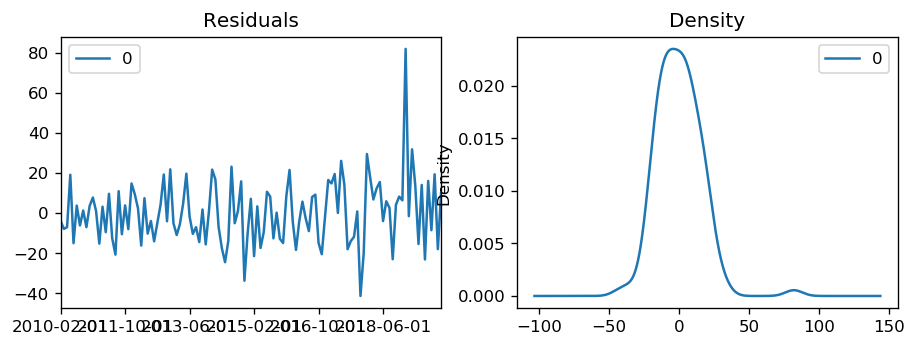

In [80]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.savefig('14-residual_error.png')

plt.show()

##### The constant mean is well fall in the significant region and the variance is nearly '0'. 

### Using actual fitted model to see how the model prediction is. Here use dynamic=False to have the laggs in the samples to be used in the model for prediction

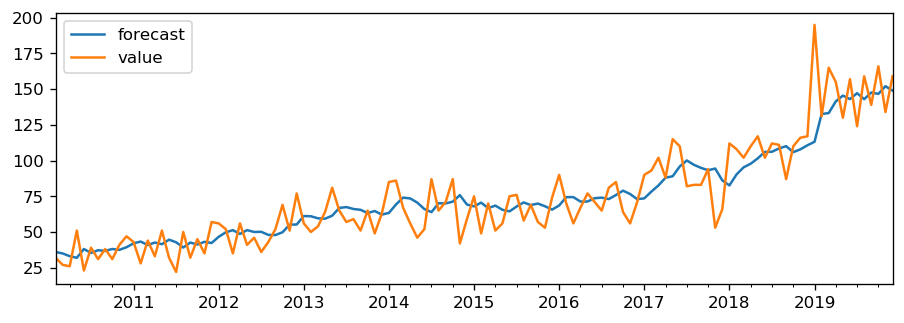

In [81]:
# Actual vs Fitted predict plot
model_fit.plot_predict(dynamic=False)
plt.savefig('15_prediction_model.png')

plt.show()

##### Without seasonality, the prediction is only fitted to the actual data trend, but this is not good fit. 

### Create the optimal ARIMA model manually using Out-of-Time Cross validation

C:\Users\foxru\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\foxru\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                   98
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -390.959
Method:                       css-mle   S.D. of innovations             12.796
Date:                Tue, 31 Mar 2020   AIC                            789.918
Time:                        00:28:20   BIC                            800.258
Sample:                    02-01-2010   HQIC                           794.100
                         - 03-01-2018                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.5965      0.056     10.593      0.000       0.486       0.707
ar.L1.D.value     0.2070      0.100      2.075      0.038       0.011       0.403
ma.L1.D.value    -1.0000      0.032    -

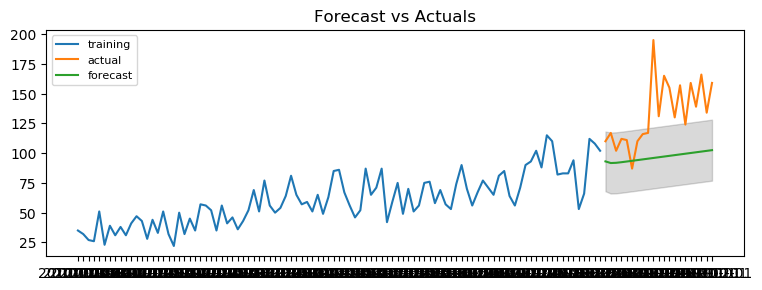

In [82]:
# Create Training and Testing sets by split the samples into 75:25 ratio
train = df.value[:99]
test = df.value[99:]

# Build ARIMA Model
model = ARIMA(train, order=(1, 1, 1))  
fitted = model.fit(disp=-1)
print(fitted.summary())

# Using the current data set to forecastting the future outcome
fc, se, conf = fitted.forecast(21, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(9,3), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.savefig('16_forecasting_by_training_model.png')

plt.show()

##### After compare the forecast against the actual trend, the forecastting is slightly below the actual value. Therefore we like to use auto arima to see what the outcome that optimal model give us

### Use auto_arima() approach to search multiple combinations of p,d,q parameters and chooses the best model that has the least AIC.

In [37]:
# Create auto arima forecasting model
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

df = pd.read_csv('2010_zip_1_monthly_data.csv', names=['value'], header=0)

model = pm.auto_arima(df.value, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
Fit ARIMA: (1, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=1002.584, BIC=1013.700, Time=0.505 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=1050.847, BIC=1056.405, Time=0.043 seconds
Fit ARIMA: (1, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=1018.878, BIC=1027.216, Time=0.247 seconds
Fit ARIMA: (0, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=1000.754, BIC=1009.092, Time=0.188 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=False); AIC=1049.180, BIC=1051.959, Time=0.051 seconds
Fit ARIMA: (0, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=1002.616, BIC=1013.732, Time=0.388 seconds
Fit ARIMA: (1, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=1002.036, BIC=1015.931, Time=0.527 seconds
Near non-invertible roots for order (1, 1, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Total fit time: 2.001 seconds
                               SARIMAX Results                                
Dep

##### The auto arima model telling us the lowest AIC is 1000, which used parameter set d=0, AR=1, MA=1. 

### Use model diagnostics plot to interpret residual errors

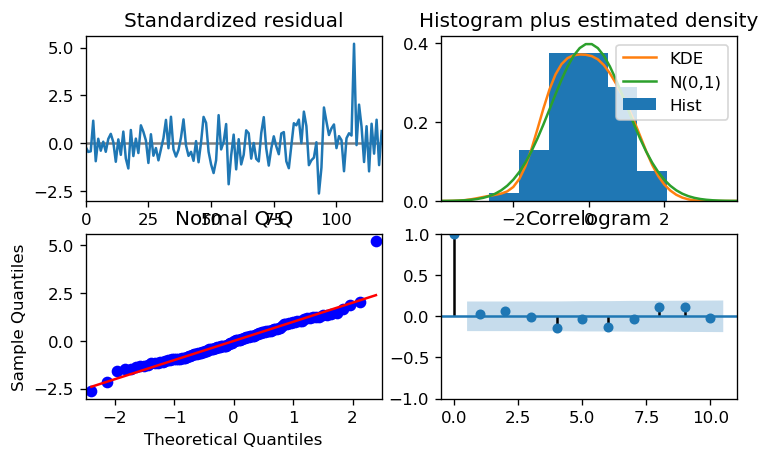

In [42]:
model.plot_diagnostics(figsize=(7,4))
plt.show()
plt.savefig('18_autoARIMA_error_diagnostics.png')
plt.show()

##### **Top left:** The residual errors seem to fluctuate around a mean of zero and have a uniform variance.

##### **Top Right**: The density plot suggest normal distribution with mean zero.

##### **Bottom left**: All the dots should fall perfectly in line with the red line. Any significant deviations would imply the distribution is skewed.

##### **Bottom Right**: The Correlogram, aka, ACF plot shows the residual errors are not autocorrelated. Any autocorrelation would imply that there is some pattern in the residual errors which are not explained in the model. So you will need to look for more X’s (predictors) to the model.

### Use our fitted training model forecastting the testing set

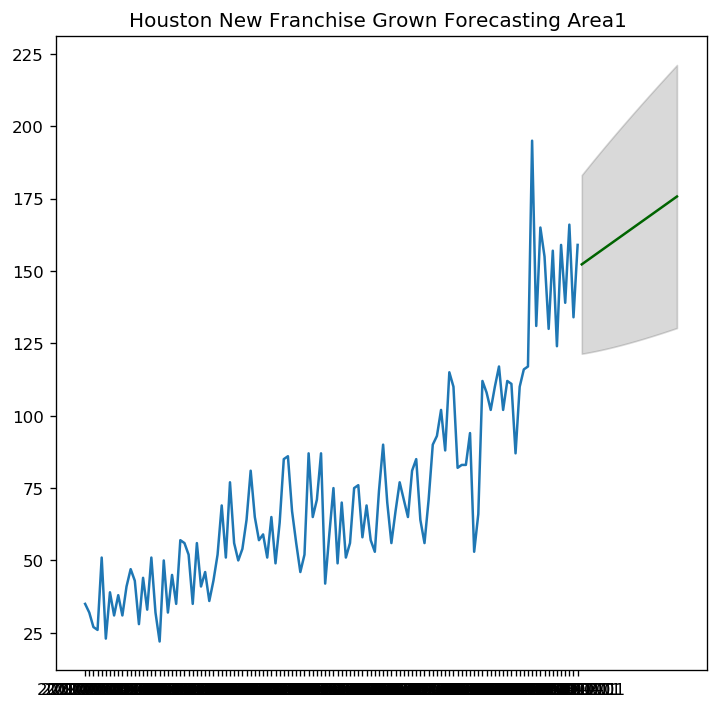

In [41]:
# Forecast
n_periods = 24
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(len(df.value), len(df.value)+n_periods)

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(df.value)
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("Houston New Franchise Grown Forecasting Area1 ")
plt.savefig('19_autoARIMA_forecasting.png')

plt.show()

##### The fitted model seems gave us the good forecastting

### Comparison of differencing between usual data and data with seasonality

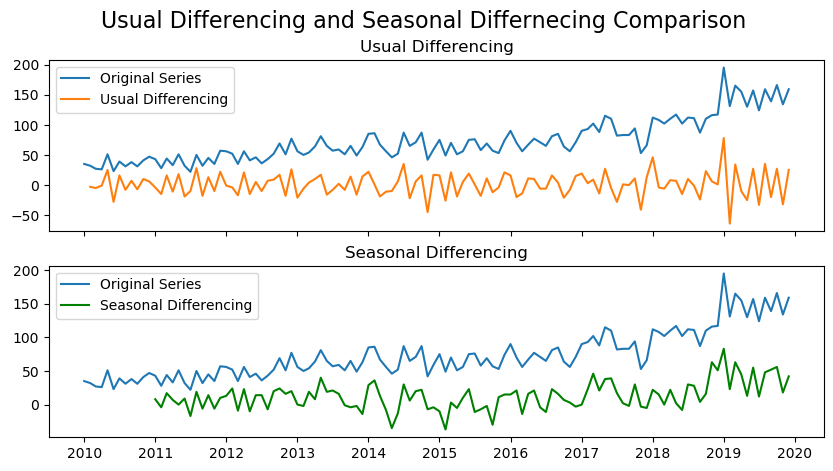

In [43]:
# Import data
data = pd.read_csv('2010_zip_1_monthly_data.csv', parse_dates=['date'], index_col='date')

# Plot setting
fig, axes = plt.subplots(2, 1, figsize=(10,5), dpi=100, sharex=True)

# Usual Differencing
axes[0].plot(data[:], label='Original Series')
axes[0].plot(data[:].diff(1), label='Usual Differencing')
axes[0].set_title('Usual Differencing')
axes[0].legend(loc='upper left', fontsize=10)


# Seasinal Dei
axes[1].plot(data[:], label='Original Series')
axes[1].plot(data[:].diff(12), label='Seasonal Differencing', color='green')
axes[1].set_title('Seasonal Differencing')
plt.legend(loc='upper left', fontsize=10)
plt.suptitle('Usual Differencing and Seasonal Differnecing Comparison', fontsize=16)
plt.savefig('20_usual_vs_seasonal_differencing.png')

plt.show()

##### The seasonal spikes much sharp before applying the seasonal differencing. The spikes ractified after seasonality added to the usual data set 

### Build SARIMAX model

In [46]:
# Seasonal - fit stepwise auto-ARIMA
smodel = pm.auto_arima(data, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
Fit ARIMA: (1, 1, 1)x(0, 1, 1, 12) (constant=True); AIC=907.492, BIC=920.856, Time=2.036 seconds
Fit ARIMA: (0, 1, 0)x(0, 1, 0, 12) (constant=True); AIC=978.751, BIC=984.097, Time=0.067 seconds
Fit ARIMA: (1, 1, 0)x(1, 1, 0, 12) (constant=True); AIC=930.620, BIC=941.312, Time=1.313 seconds
Fit ARIMA: (0, 1, 1)x(0, 1, 1, 12) (constant=True); AIC=905.682, BIC=916.373, Time=1.016 seconds
Fit ARIMA: (0, 1, 0)x(0, 1, 0, 12) (constant=False); AIC=976.771, BIC=979.444, Time=0.043 seconds
Fit ARIMA: (0, 1, 1)x(0, 1, 0, 12) (constant=True); AIC=932.747, BIC=940.766, Time=0.217 seconds
Fit ARIMA: (0, 1, 1)x(1, 1, 1, 12) (constant=True); AIC=907.663, BIC=921.027, Time=2.091 seconds
Fit ARIMA: (0, 1, 1)x(0, 1, 2, 12) (constant=True); AIC=907.666, BIC=921.030, Time=3.106 seconds
Fit ARIMA: (0, 1, 1)x(1, 1, 0, 12) (constant=True); AIC=912.483, BIC=923.175, Time=0.793 seconds
Fit ARIMA: (0, 1, 1)x(1, 1, 2, 12) (constant=True); AIC=909.133, BIC=925.170, Time=

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  120
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -448.841
Date:                            Tue, 31 Mar 2020   AIC                            905.682
Time:                                    03:58:14   BIC                            916.373
Sample:                                         0   HQIC                           910.016
                                            - 120                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2512      0.144      1.743      0.081      -0.031       0.534
ma.L1         -0.7883      0.060    -13.178      0.000      -0.906      -0.671
ma.S.L12      -0.6618      0.114     -5.793      0.000      -0.886      -0.438
sigma2       239.2016     29.020      8.243      0.000     182.323     296.081
===================================================================================
Ljung-Box (Q):                       35.56   Jarque-Bera (JB):                 6.70
Prob(Q):                              0.67   Prob(JB):                         0.04
Heteroskedasticity (H):               2.93   Skew:                             0.36
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

##### After adding the seasonality to the ARIMA model, model fit our data more better because the AIC dropped again.

### Build residual interpretation diagnostics plots for SARIMAX model

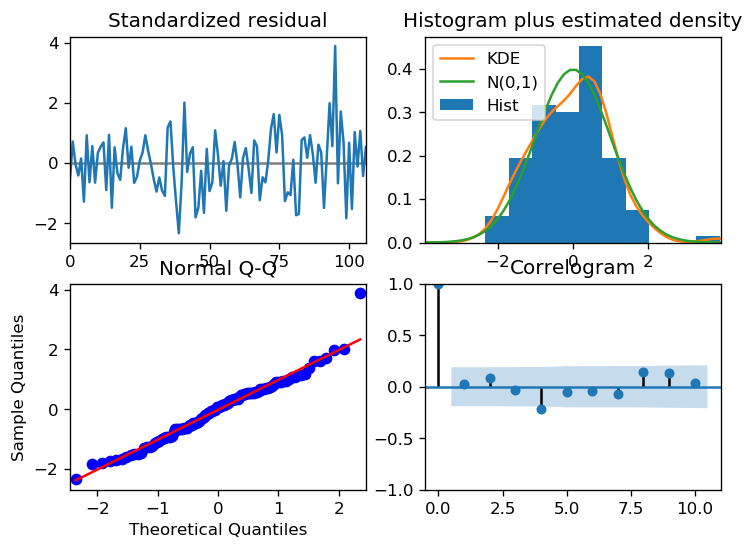

In [47]:
smodel.plot_diagnostics(figsize=(7,5))
plt.show()

### Use SARIMAX model to forecastting (X is by adding exogenous vatiable in the model, like seasonal_index)

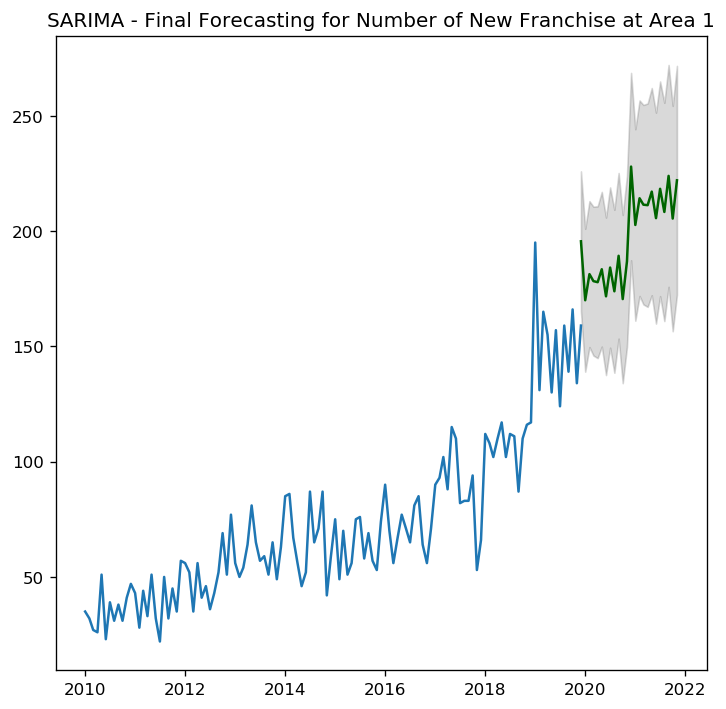

In [48]:
# Build SARIMAX forecastting model
n_periods = 24
fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(data.index[-1], periods = n_periods, freq='MS')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(data)
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("SARIMA - Final Forecasting for Number of New Franchise at Area 1")
plt.savefig('23_SARIMA_forcasting.png')

plt.show()

##### The SARIMA is again well predicted the forecastting

### Building SARIMAX Model with exogenous variable

In [51]:
# Compute Seasonal Index

# Import Data
data = pd.read_csv('2010_zip_1_monthly_data.csv', parse_dates=['date'], index_col='date')

from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

# multiplicative seasonal component
result_mul = seasonal_decompose(data['value'][-36:],   # 3 years
                                model='multiplicative', 
                                extrapolate_trend='freq')

seasonal_index = result_mul.seasonal[-12:].to_frame()
seasonal_index['month'] = pd.to_datetime(seasonal_index.index).month

# merge with the base data
data['month'] = data.index.month
df = pd.merge(data, seasonal_index, how='left', on='month')
df.columns = ['value', 'month', 'seasonal_index']
df.index = data.index  # reassign the index.

# SARIMAX Model
sxmodel = pm.auto_arima(df[['value']], exogenous=df[['seasonal_index']],
                           start_p=1, start_q=1,
                           test='adf',
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=None, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

sxmodel.summary()

Performing stepwise search to minimize aic
Fit ARIMA: (1, 0, 1)x(0, 1, 1, 12) (constant=True); AIC=918.174, BIC=934.267, Time=3.504 seconds
Fit ARIMA: (0, 0, 0)x(0, 1, 0, 12) (constant=True); AIC=966.778, BIC=974.824, Time=0.223 seconds
Fit ARIMA: (1, 0, 0)x(1, 1, 0, 12) (constant=True); AIC=941.173, BIC=954.583, Time=1.500 seconds
Fit ARIMA: (0, 0, 1)x(0, 1, 1, 12) (constant=True); AIC=950.824, BIC=964.234, Time=1.369 seconds
Fit ARIMA: (0, 0, 0)x(0, 1, 0, 12) (constant=False); AIC=1000.269, BIC=1005.633, Time=0.329 seconds
Fit ARIMA: (1, 0, 1)x(0, 1, 0, 12) (constant=True); AIC=944.595, BIC=958.005, Time=0.877 seconds
Fit ARIMA: (1, 0, 1)x(1, 1, 1, 12) (constant=True); AIC=920.172, BIC=938.947, Time=3.500 seconds
Fit ARIMA: (1, 0, 1)x(0, 1, 2, 12) (constant=True); AIC=920.172, BIC=938.947, Time=11.338 seconds
Fit ARIMA: (1, 0, 1)x(1, 1, 0, 12) (constant=True); AIC=925.270, BIC=941.363, Time=2.205 seconds
Fit ARIMA: (1, 0, 1)x(1, 1, 2, 12) (constant=True); AIC=921.760, BIC=943.217, Ti

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  120
Model:             SARIMAX(1, 0, 1)x(0, 1, 1, 12)   Log Likelihood                -453.087
Date:                            Tue, 31 Mar 2020   AIC                            918.174
Time:                                    04:02:54   BIC                            934.267
Sample:                                01-01-2010   HQIC                           924.699
                                     - 12-01-2019                                         
Covariance Type:                              opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept          0.3065      0.513      0.597      0.550      -0.699       1.312
seasonal_index    -0.0007   3.99e+04  -1.77e-08      1.000   -7.82e+04    7.82e+04
ar.L1              0.9776      0.046     21.096      0.000       0.887       1.068
ma.L1             -0.7318      0.097     -7.582      0.000      -0.921      -0.543
ma.S.L12          -0.6761      0.115     -5.901      0.000      -0.901      -0.452
sigma2           241.0973     29.747      8.105      0.000     182.794     299.401
===================================================================================
Ljung-Box (Q):                       35.42   Jarque-Bera (JB):                 8.76
Prob(Q):                              0.68   Prob(JB):                         0.01
Heteroskedasticity (H):               3.27   Skew:                             0.45
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

##### After we made the SARIMA model, we added SARIMA index and try to see if SARIMAX model can be used with exogenon variable. However, the index value showed it failed to the significant test. Therefore, we believe SARIMA is the best model for our data's forecastting. 

##### Our project machine learning time series model resources from: https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/, https://www.machinelearningplus.com/time-series/time-series-analysis-python/, and https://www.machinelearningplus.com/time-series/time-series-analysis-python/